<a href="https://colab.research.google.com/github/emery1189/regression_diamonds_houses/blob/main/regression_diamonds_houses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 💎 🏡 Regression

in this notebook, we will explore two Kaggle datasets: [Diamonds](https://www.kaggle.com/datasets/vittoriogiatti/diamondprices) and [Austin House Prices](https://www.kaggle.com/datasets/alexhuggler/austin-zillow-houses-for-sale).

we will:
- complete a brief EDA on both datasets
- train regression models on the datasets
- score the model on a test subset of each dataset
- create a function to intake information about a diamond and predict a price
- create a function to intake information about a house and predict a price
- create a function to covert the price of an Austin house into diamonds.


this should help to answer the burning question:

how many diamonds do i need to buy a house in Austin?

<font size=8> 🛠️ 🪛 🪚</font>

installs and imports

In [1]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

In [4]:
!kaggle datasets download vittoriogiatti/diamondprices

  0% 0.00/586k [00:00<?, ?B/s]
100% 586k/586k [00:00<00:00, 90.9MB/s]


In [5]:
!unzip /content/diamondprices.zip

Archive:  /content/diamondprices.zip
  inflating: DiamondsPrices.csv      


## 💎 Diamonds

### EDA 🔎

In [6]:
diamonds = pd.read_csv("/content/DiamondsPrices.csv")

In [7]:
diamonds

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75
...,...,...,...,...,...,...,...,...,...,...
53935,0.72,Ideal,D,SI1,60.8,57.0,2757,5.75,5.76,3.50
53936,0.72,Good,D,SI1,63.1,55.0,2757,5.69,5.75,3.61
53937,0.70,Very Good,D,SI1,62.8,60.0,2757,5.66,5.68,3.56
53938,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74


so we have a DataFrame of diamond information.

each row has information about a diamond, including its 4 C's (carat, cut, color, and clarity) as well as its depth, table, and measurements and, of course, its price.

there are 53,940 rows in the DataFrame, which gives us plenty of training examples. we'll use these training examples to train a model to predict the price of diamond it has not seen before based on the above attributes. these attributes should be relatively easy for anyone to obtain.

In [8]:
diamonds.carat.mean(), diamonds.carat.median()

(0.7979397478680014, 0.7)

In [9]:
diamonds.describe()

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


In [10]:
diamonds.max()

carat           5.01
cut        Very Good
color              J
clarity         VVS2
depth           79.0
table           95.0
price          18823
x              10.74
y               58.9
z               31.8
dtype: object

In [11]:
diamonds.mean()

<ipython-input-11-058eca819fc0>:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  diamonds.mean()


carat       0.797940
depth      61.749405
table      57.457184
price    3932.799722
x           5.731157
y           5.734526
z           3.538734
dtype: float64

In [12]:
diamonds.cut.value_counts()

Ideal        21551
Premium      13791
Very Good    12082
Good          4906
Fair          1610
Name: cut, dtype: int64

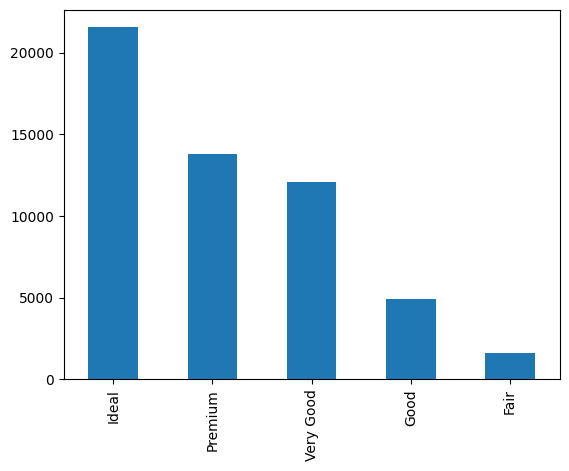

In [13]:
diamonds.cut.value_counts().plot(kind="bar");

In [14]:
diamonds.clarity.value_counts()

SI1     13065
VS2     12258
SI2      9194
VS1      8171
VVS2     5066
VVS1     3655
IF       1790
I1        741
Name: clarity, dtype: int64

In [15]:
diamonds.color.value_counts()

G    11292
E     9797
F     9542
H     8304
D     6775
I     5422
J     2808
Name: color, dtype: int64

we have 3 non-numeric columns in our data.

we'll use panda's `get_dummies()` to one-hot encode these values.

In [16]:
diamonds = pd.get_dummies(diamonds, columns=["cut", "color", "clarity"])
diamonds

,carat,depth,table,price,x,y,z,cut_Fair,cut_Good,cut_Ideal,...,color_I,color_J,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.23,61.5,55.0,326,3.95,3.98,2.43,0,0,1,...,0,0,0,0,0,1,0,0,0,0
1,0.21,59.8,61.0,326,3.89,3.84,2.31,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2,0.23,56.9,65.0,327,4.05,4.07,2.31,0,1,0,...,0,0,0,0,0,0,1,0,0,0
3,0.29,62.4,58.0,334,4.20,4.23,2.63,0,0,0,...,1,0,0,0,0,0,0,1,0,0
4,0.31,63.3,58.0,335,4.34,4.35,2.75,0,1,0,...,0,1,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53935,0.72,60.8,57.0,2757,5.75,5.76,3.50,0,0,1,...,0,0,0,0,1,0,0,0,0,0
53936,0.72,63.1,55.0,2757,5.69,5.75,3.61,0,1,0,...,0,0,0,0,1,0,0,0,0,0
53937,0.70,62.8,60.0,2757,5.66,5.68,3.56,0,0,0,...,0,0,0,0,1,0,0,0,0,0
53938,0.86,61.0,58.0,2757,6.15,6.12,3.74,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [17]:
X = diamonds.drop(["price"], axis=1)
y = diamonds.price

In [18]:
X.head()

,carat,depth,table,x,y,z,cut_Fair,cut_Good,cut_Ideal,cut_Premium,...,color_I,color_J,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.23,61.5,55.0,3.95,3.98,2.43,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
1,0.21,59.8,61.0,3.89,3.84,2.31,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,0.23,56.9,65.0,4.05,4.07,2.31,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
3,0.29,62.4,58.0,4.20,4.23,2.63,0,0,0,1,...,1,0,0,0,0,0,0,1,0,0
4,0.31,63.3,58.0,4.34,4.35,2.75,0,1,0,0,...,0,1,0,0,0,1,0,0,0,0


#### normalizing values

In [19]:
X_normalized = (X - X.min()) / (X.max() - X.min())

X_normalized.head()

,carat,depth,table,x,y,z,cut_Fair,cut_Good,cut_Ideal,cut_Premium,...,color_I,color_J,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.006237,0.513889,0.230769,0.367784,0.067572,0.076415,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.002079,0.466667,0.346154,0.362197,0.065195,0.072642,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,0.006237,0.386111,0.423077,0.377095,0.069100,0.072642,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
3,0.018711,0.538889,0.288462,0.391061,0.071817,0.082704,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.022869,0.563889,0.288462,0.404097,0.073854,0.086478,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train_norm, X_test_norm, y_train_norm, y_test_norm = train_test_split(X_normalized, y, test_size=0.2)

len(X_train), len(X_test), len(y_train), len(y_test), len(X_train_norm), len(y_test_norm)

(43152, 10788, 43152, 10788, 43152, 10788)

### baseline model (.89 r2 score)

In [21]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(64),
    tf.keras.layers.Dense(1)
])

model.compile(loss="mae",
              optimizer="adam",
              metrics=["mae"])

model.fit(X_train,
          y_train,
          epochs=50,
          verbose=0)

In [22]:
y_pred = model.predict(X_test)

338/338 [==============================] - 1s 1ms/step


In [23]:
# let's take a look at one of our predictions

y_pred[29]

array([901.5325], dtype=float32)

In [24]:
model.evaluate(X_test, y_test)

338/338 [==============================] - 1s 2ms/step - loss: 851.3113 - mae: 851.3113


[851.311279296875, 851.311279296875]

In [25]:
print(f"""
baseline:
test r2: {r2_score(y_true=y_test , y_pred=y_pred)}
test mae: {mean_absolute_error(y_true=y_test, y_pred=y_pred)}
""")


baseline:
test r2: 0.8711374191071994
test mae: 851.3114227608128



.87 r2 score for baseline model.

not bad!

does it do any better on normalized data?

In [26]:
model.fit(X_train_norm,
          y_train_norm,
          epochs=50,
          verbose=0)

In [27]:
y_pred_norm = model.predict(X_test_norm)

338/338 [==============================] - 1s 2ms/step


In [28]:
print(f"""
baseline (normalized):
test r2: {r2_score(y_true=y_test_norm , y_pred=y_pred_norm)}
test mae: {mean_absolute_error(y_true=y_test_norm, y_pred=y_pred_norm)}
""")


baseline (normalized):
test r2: 0.8928029361427912
test mae: 767.924293617623



### LinearRegression model (.92 r2 score)

In [29]:
model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [30]:
print(f"""
linear regression:
test r2: {r2_score(y_test , y_pred)}
test mae: {mean_absolute_error(y_test, y_pred)}
""")


linear regression:
test r2: 0.9214520116105955
test mae: 749.931048966137



.92!

moving in the right direction.

any improvement with normalized data?

In [31]:
model.fit(X_train_norm, y_train_norm)

y_pred_norm = model.predict(X_test_norm)

In [32]:
print(f"""
linear regression (normalized):
test r2: {r2_score(y_test_norm , y_pred_norm)}
test mae: {mean_absolute_error(y_test_norm, y_pred_norm)}
""")


linear regression (normalized):
test r2: 0.9198228069887945
test mae: 744.2754737433507



### SGDRegressor model 🚫

In [33]:
model = SGDRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [34]:
print(f"""
SGD regressor:
test r2: {r2_score(y_test , y_pred)}
test mae: {mean_absolute_error(y_test, y_pred)}
""")


SGD regressor:
test r2: -2042164607.6168466
test mae: 142592415.18719208



uninspiring.

### RandomForestRegressor model ❕ (.98 r2 score)

In [35]:
diamond_model = RandomForestRegressor()
diamond_model.fit(X_train, y_train)

y_pred = diamond_model.predict(X_test)

In [36]:
print(f"""
random forest:
test r2: {r2_score(y_true=y_test, y_pred=y_pred)}
test mae: {mean_absolute_error(y_true=y_test, y_pred=y_pred)}
""")


random forest:
test r2: 0.9811903441539322
test mae: 271.1498247126437



<font size=6>🔥🔥🔥</font>

.98 r2 score!

In [37]:
model = RandomForestRegressor()
model.fit(X_train_norm, y_train_norm)

y_pred_norm = model.predict(X_test_norm)

In [38]:
print(f"""
random forest (normalized):
test r2: {r2_score(y_test_norm , y_pred_norm)}
test mae: {mean_absolute_error(y_test_norm, y_pred_norm)}
""")


random forest (normalized):
test r2: 0.9805037542728409
test mae: 271.9612663188375



normalizing our data yielded negligible improvement.

based on our experiments, it makes sense to use a `RandomForestRegressor()` with non-normalized data. using non-normalized data should make predicting on user-inputted diamond characteristics simpler.

### creating a `tell_me_about_your_diamond()` function to take in user input

In [39]:
X_test.columns

Index(['carat', 'depth', 'table', 'x', 'y', 'z', 'cut_Fair', 'cut_Good',
       'cut_Ideal', 'cut_Premium', 'cut_Very Good', 'color_D', 'color_E',
       'color_F', 'color_G', 'color_H', 'color_I', 'color_J', 'clarity_I1',
       'clarity_IF', 'clarity_SI1', 'clarity_SI2', 'clarity_VS1',
       'clarity_VS2', 'clarity_VVS1', 'clarity_VVS2'],
      dtype='object')

In [42]:
def tell_me_about_your_diamond():
  global diamond_price
  specifics = input("do you have specific information (carat, cut, color, etc.) about your diamond?\nor would you like to use defaults? please type 'specifics' or 'defaults': ")

  if specifics == "specifics" or specifics == "specific":
    your_diamond = pd.DataFrame(columns=['carat', 'depth', 'table', 'x', 'y', 'z', 'cut_Fair', 'cut_Good',
       'cut_Ideal', 'cut_Premium', 'cut_Very Good', 'color_D', 'color_E',
       'color_F', 'color_G', 'color_H', 'color_I', 'color_J', 'clarity_I1',
       'clarity_IF', 'clarity_SI1', 'clarity_SI2', 'clarity_VS1',
       'clarity_VS2', 'clarity_VVS1', 'clarity_VVS2'])
    carat = input("how many carats is your diamond? ")
    depth = input("please enter the depth of your diamond: ")
    table = input("please enter the table of your diamond: ")
    x = input("please enter the length of your diamond: ")
    y = input("please enter the width of your diamond: ")
    z = input("please enter the height of your diamond: ")
    cut = input("what is the cut of your diamond? \nIdeal / Premium / Very Good / Good / Fair: ").title()
    color = input("what is the color of your diamond? \nD / E / F / G / H / I / J: ").capitalize()
    clarity = input("what is the clarity of your diamond? \nIF / I1 / SI1 / SI2 / VS1 / VS2 / VVS1 / VVS2: ").upper()

    df1 = pd.DataFrame(data=[[carat, depth, table, x, y, z, cut, color, clarity]],columns=['carat', 'depth', 'table', 'x', 'y', 'z', 'cut', 'color', 'clarity'])
    df1 = pd.get_dummies(df1, columns=['cut', 'color', 'clarity'])
    your_diamond = pd.concat([your_diamond, df1], axis=0)
    your_diamond = your_diamond.fillna(0)

    diamond_price = diamond_model.predict(your_diamond)
    diamond_price = tf.squeeze(diamond_price).numpy()
    print(f"\n\nthank you for the information!\nyour diamond is worth ${diamond_price}")

  elif specifics == "defaults" or specifics == "default":
    grade = input("great! we'll use defaults. \nwould you like good, better, or best quality diamonds? ")
    if grade == "good":
      print("fine choice!\n$2,919 per diamond\ngood diamond specifics:\ncarats: 0.7\ndepth: 61.8\ntable: 57\nmeasurements:5.7 x 5.7 x 3.5\ncolor: F\ncut: very good\nclarity:VS1")
      diamond_price = 2919
    elif grade == "better":
      print("wonderful taste!\n$6,779 per diamond\nbetter diamond specifics:\ncarats: 1\ndepth: 62.5\ntable: 59\nmeasurements:6.5 x 6.5 x 4\ncolor: E\ncut: premium\nclarity:VS2")
      diamond_price = 6779
    elif grade == "best":
      print("superb!\n$15,841 per diamond\nbest diamond specifics:\ncarats: 2\ndepth: 64.7\ntable: 63\nmeasurements:8.18 x 8.17 x 5.05\ncolor: D\ncut: ideal\nclarity:VVS2")
      diamond_price = 15841
    else:
      print("please enter 'good', 'better', or 'best'.")
      tell_me_about_your_diamond()
  else:
    print("please enter 'specifics' or 'defaults'.")
    tell_me_about_your_diamond()

  return diamond_price

In [43]:
tell_me_about_your_diamond()

do you have specific information (carat, cut, color, etc.) about your diamond?
or would you like to use defaults? please type 'specifics' or 'defaults': specifics
how many carats is your diamond? .4
please enter the depth of your diamond: 71.8
please enter the table of your diamond: 72
please enter the length of your diamond: 4.16
please enter the width of your diamond: 3.93
please enter the height of your diamond: 2.82
what is the cut of your diamond? 
Ideal / Premium / Very Good / Good / Fair: very good
what is the color of your diamond? 
D / E / F / G / H / I / J: e
what is the clarity of your diamond? 
IF / I1 / SI1 / SI2 / VS1 / VS2 / VVS1 / VVS2: vs2


thank you for the information!
your diamond is worth $586.47


586.47

In [44]:
tell_me_about_your_diamond()

do you have specific information (carat, cut, color, etc.) about your diamond?
or would you like to use defaults? please type 'specifics' or 'defaults': specifics
how many carats is your diamond? 2
please enter the depth of your diamond: 64.7
please enter the table of your diamond: 63
please enter the length of your diamond: 8.18
please enter the width of your diamond: 8.17
please enter the height of your diamond: 5.05
what is the cut of your diamond? 
Ideal / Premium / Very Good / Good / Fair: ideal
what is the color of your diamond? 
D / E / F / G / H / I / J: d
what is the clarity of your diamond? 
IF / I1 / SI1 / SI2 / VS1 / VS2 / VVS1 / VVS2: vvs2


thank you for the information!
your diamond is worth $16387.37


16387.37

In [45]:
tell_me_about_your_diamond()

do you have specific information (carat, cut, color, etc.) about your diamond?
or would you like to use defaults? please type 'specifics' or 'defaults': defaults
great! we'll use defaults. 
would you like good, better, or best quality diamonds? better
wonderful taste!
$6,779 per diamond
better diamond specifics:
carats: 1
depth: 62.5
table: 59
measurements:6.5 x 6.5 x 4
color: E
cut: premium
clarity:VS2


6779

## 🏡 Houses

In [46]:
!kaggle datasets download alexhuggler/austin-zillow-houses-for-sale

  0% 0.00/39.6k [00:00<?, ?B/s]
100% 39.6k/39.6k [00:00<00:00, 74.3MB/s]


In [47]:
!unzip /content/austin-zillow-houses-for-sale.zip

Archive:  /content/austin-zillow-houses-for-sale.zip
  inflating: Zillow_Austin_11-16-22.csv  


### EDA 🔎

In [48]:
houses = pd.read_csv("/content/Zillow_Austin_11-16-22.csv")

houses

,price,unformattedPrice,address,addressStreet,addressCity,addressState,addressZipcode,beds,baths,area,latitude,longitude,isZillowOwned,variableData,badgeInfo,pgapt,sgapt,zestimate,info3String,brokerName
0,445000,445000,"8916 Mountain Shadows Cv APT B, Austin, TX 78735",8916 Mountain Shadows Cv APT B,Austin,TX,78735,3.0,3.0,1802.0,30.269207,-97.862060,False,"{'type': 'PRICE_REDUCTION', 'text': '$20,000 (...",NaN,ForSale,For Sale (Broker),1189900,https://photos.zillowstatic.com/fp/98ab7c7b289...,Realty Austin
1,1995000,1995000,"1701 Alguno Rd, Austin, TX 78757",1701 Alguno Rd,Austin,TX,78757,4.0,4.0,3443.0,30.333755,-97.734140,False,"{'type': 'DAYS_ON', 'text': '19 days on Zillow'}",NaN,ForSale,New Construction,2154600,https://photos.zillowstatic.com/fp/98ab7c7b289...,Jimmy Gilmore & Co
2,929900,929900,"1800 Kinney Ave, Austin, TX 78704",1800 Kinney Ave,Austin,TX,78704,2.0,2.0,1318.0,30.252070,-97.768600,False,"{'type': 'OPEN_HOUSE', 'text': 'Open: Sat. 2-4...",NaN,ForSale,For Sale (Broker),1048700,https://photos.zillowstatic.com/fp/98ab7c7b289...,Keller Williams Realty
3,6495000,6495000,"2407 Pemberton Pl, Austin, TX 78703",2407 Pemberton Pl,Austin,TX,78703,5.0,6.0,5000.0,30.290514,-97.753610,False,"{'type': 'PRICE_REDUCTION', 'text': '$500,000 ...",NaN,ForSale,For Sale (Broker),6553400,https://photos.zillowstatic.com/fp/98ab7c7b289...,Douglas Elliman Real Estate
4,365000,365000,"11701 Lansdowne Rd, Austin, TX 78754",11701 Lansdowne Rd,Austin,TX,78754,4.0,2.0,2127.0,30.355240,-97.612920,False,"{'type': '3D_HOME', 'text': '3D Tour'}",NaN,ForSale,For Sale (Broker),421000,https://photos.zillowstatic.com/fp/98ab7c7b289...,Orchard Brokerage
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,9990000,9990000,"1209 N Weston Ln, Austin, TX 78733",1209 N Weston Ln,Austin,TX,78733,5.0,8.0,8357.0,30.326190,-97.844025,False,"{'type': 'DAYS_ON', 'text': '97 days on Zillow'}",NaN,ForSale,For Sale (Broker),0,https://photos.zillowstatic.com/fp/98ab7c7b289...,Moreland Properties
796,11250800,11250800,"3603 Stoneridge Rd, Austin, TX 78746",3603 Stoneridge Rd,Austin,TX,78746,5.0,8.0,7947.0,NaN,NaN,False,"{'type': 'DAYS_ON', 'text': '78 days on Zillow'}",NaN,ForSale,New Construction,0,https://photos.zillowstatic.com/fp/98ab7c7b289...,Moreland Properties
797,13000000,13000000,"1301 W 29th St, Austin, TX 78703",1301 W 29th St,Austin,TX,78703,5.0,7.0,6528.0,30.299100,-97.749725,False,"{'type': 'DAYS_ON', 'text': '39 days on Zillow'}",NaN,ForSale,For Sale (Broker),0,https://photos.zillowstatic.com/fp/98ab7c7b289...,"Compass RE Texas, LLC"
798,13500000,13500000,"7849 Escala Dr, Austin, TX 78735",7849 Escala Dr,Austin,TX,78735,5.0,7.0,8549.0,30.271202,-97.867645,False,"{'type': 'PRICE_REDUCTION', 'text': '$1,499,00...",NaN,ForSale,For Sale (Broker),0,https://photos.zillowstatic.com/fp/98ab7c7b289...,Moreland Properties


In [49]:
houses.columns

Index(['price', 'unformattedPrice', 'address', 'addressStreet', 'addressCity',
       'addressState', 'addressZipcode', 'beds', 'baths', 'area', 'latitude',
       'longitude', 'isZillowOwned', 'variableData', 'badgeInfo', 'pgapt',
       'sgapt', 'zestimate', 'info3String', 'brokerName'],
      dtype='object')

In [50]:
houses.describe()

,price,unformattedPrice,addressZipcode,beds,baths,area,latitude,longitude,badgeInfo,zestimate
count,8.000000e+02,8.000000e+02,800.00000,785.000000,799.000000,796.000000,786.000000,786.000000,0.0,8.000000e+02
mean,9.696823e+05,9.696823e+05,78734.11500,3.331210,2.675845,2142.964824,30.293275,-97.764621,NaN,1.815941e+05
std,1.478447e+06,1.478447e+06,21.51576,0.976696,1.215524,1317.309700,0.092231,0.080536,NaN,5.112124e+05
min,9.990000e+04,9.990000e+04,78617.00000,0.000000,0.000000,391.000000,30.103233,-98.019940,NaN,0.000000e+00
25%,4.247500e+05,4.247500e+05,78724.00000,3.000000,2.000000,1386.000000,30.218251,-97.812345,NaN,0.000000e+00
50%,5.899500e+05,5.899500e+05,78739.00000,3.000000,2.000000,1840.500000,30.283288,-97.756465,NaN,0.000000e+00
75%,8.193750e+05,8.193750e+05,78748.00000,4.000000,3.000000,2493.000000,30.364248,-97.714425,NaN,2.931110e+05
max,1.800000e+07,1.800000e+07,78759.00000,7.000000,10.000000,14025.000000,30.516008,-97.570600,NaN,6.553400e+06


In [51]:
houses.median()

<ipython-input-51-bdde9a54c268>:1: FutureWarning: The default value of numeric_only in DataFrame.median is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  houses.median()


price               589950.000000
unformattedPrice    589950.000000
addressZipcode       78739.000000
beds                     3.000000
baths                    2.000000
area                  1840.500000
latitude                30.283288
longitude              -97.756465
isZillowOwned            0.000000
badgeInfo                     NaN
zestimate                0.000000
dtype: float64

<Axes: >

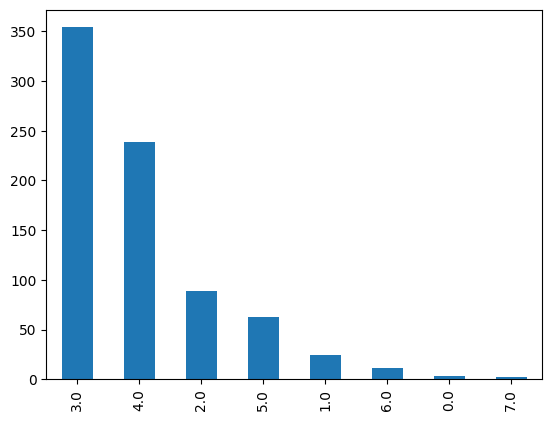

In [52]:
houses.beds.value_counts().plot(kind="bar")

In [53]:
houses.beds.value_counts()

3.0    354
4.0    239
2.0     89
5.0     63
1.0     24
6.0     11
0.0      3
7.0      2
Name: beds, dtype: int64

<font size=8>🤔</font>

so we have 3 houses with 0 bedrooms?

In [54]:
houses.baths.value_counts()

2.0     334
3.0     266
4.0      87
1.0      51
5.0      20
0.0      16
6.0      12
7.0       6
8.0       5
10.0      1
9.0       1
Name: baths, dtype: int64

<font size=8>🤔</font>

and 16 houses with 0 bathrooms?

and 24 houses with 6+ bathrooms?

this is definitely information we'd want to double check with the data owner, but we'll press on here.

let's see if we can get a closer look at these occurrences.

In [55]:
houses.loc[houses["beds"] == 0]

,price,unformattedPrice,address,addressStreet,addressCity,addressState,addressZipcode,beds,baths,area,latitude,longitude,isZillowOwned,variableData,badgeInfo,pgapt,sgapt,zestimate,info3String,brokerName
56,215000,215000,"2529 Rio Grande St APT 64, Austin, TX 78705",2529 Rio Grande St APT 64,Austin,TX,78705,0.0,1.0,393.0,30.290071,-97.744060,False,"{'type': 'DAYS_ON', 'text': '25 days on Zillow'}",NaN,ForSale,For Sale (Broker),209856,https://photos.zillowstatic.com/fp/98ab7c7b289...,Campus Condos
207,175000,175000,"9313 Independence Loop, Austin, TX 78748",9313 Independence Loop,Austin,TX,78748,0.0,0.0,NaN,30.174772,-97.813126,False,"{'type': 'DAYS_ON', 'text': '194 days on Zillow'}",NaN,ForSale,For Sale (Broker),0,https://photos.zillowstatic.com/fp/98ab7c7b289...,Realty Austin
218,250000,250000,"5103 Rob Scott St, Austin, TX 78721",5103 Rob Scott St,Austin,TX,78721,0.0,0.0,NaN,30.281440,-97.679220,False,"{'type': 'DAYS_ON', 'text': '30 days on Zillow'}",NaN,ForSale,For Sale (Broker),0,https://photos.zillowstatic.com/fp/98ab7c7b289...,"Compass RE Texas, LLC"


In [56]:
houses.loc[houses["baths"] == 0]

,price,unformattedPrice,address,addressStreet,addressCity,addressState,addressZipcode,beds,baths,area,latitude,longitude,isZillowOwned,variableData,badgeInfo,pgapt,sgapt,zestimate,info3String,brokerName
44,465000,465000,"9709 Point Vista Pl, Austin, TX 78753",9709 Point Vista Pl,Austin,TX,78753,NaN,0.0,2160.0,30.357817,-97.677740,False,"{'type': 'PRICE_REDUCTION', 'text': '$5,000 (O...",NaN,ForSale,For Sale (Broker),460500,https://photos.zillowstatic.com/fp/98ab7c7b289...,Austin City Living
83,384900,384900,"6808 Wentworth Dr, Austin, TX 78724",6808 Wentworth Dr,Austin,TX,78724,NaN,0.0,1826.0,30.295020,-97.630450,False,"{'type': 'PRICE_REDUCTION', 'text': '$15,000 (...",NaN,ForSale,For Sale (Broker),376532,https://photos.zillowstatic.com/fp/98ab7c7b289...,Keller Williams Realty
166,699000,699000,"1605 Rutland Dr, Austin, TX 78758",1605 Rutland Dr,Austin,TX,78758,NaN,0.0,1958.0,30.371239,-97.710140,False,"{'type': 'PRICE_REDUCTION', 'text': '$36,000 (...",NaN,ForSale,For Sale (Broker),677156,https://photos.zillowstatic.com/fp/98ab7c7b289...,"Local Life Realty, LLC"
180,499900,499900,"5603 Purple Sage Dr, Austin, TX 78724",5603 Purple Sage Dr,Austin,TX,78724,NaN,0.0,1820.0,30.309175,-97.654880,False,"{'type': 'DAYS_ON', 'text': '5 days on Zillow'}",NaN,ForSale,For Sale (Broker),472610,https://photos.zillowstatic.com/fp/98ab7c7b289...,Keller Williams Realty
205,150000,150000,"Tbd Von Quintus Rd, Austin, TX 78719",Tbd Von Quintus Rd,Austin,TX,78719,NaN,0.0,NaN,30.103233,-97.669850,False,"{'type': 'PRICE_REDUCTION', 'text': '$25,000 (...",NaN,ForSale,For Sale (Broker),0,NaN,"Countywide Realty, Lp"
207,175000,175000,"9313 Independence Loop, Austin, TX 78748",9313 Independence Loop,Austin,TX,78748,0.0,0.0,NaN,30.174772,-97.813126,False,"{'type': 'DAYS_ON', 'text': '194 days on Zillow'}",NaN,ForSale,For Sale (Broker),0,https://photos.zillowstatic.com/fp/98ab7c7b289...,Realty Austin
218,250000,250000,"5103 Rob Scott St, Austin, TX 78721",5103 Rob Scott St,Austin,TX,78721,0.0,0.0,NaN,30.281440,-97.679220,False,"{'type': 'DAYS_ON', 'text': '30 days on Zillow'}",NaN,ForSale,For Sale (Broker),0,https://photos.zillowstatic.com/fp/98ab7c7b289...,"Compass RE Texas, LLC"
337,420000,420000,"2912 Pecan Springs Rd, Austin, TX 78723",2912 Pecan Springs Rd,Austin,TX,78723,NaN,0.0,1173.0,30.300507,-97.683420,False,"{'type': 'PRICE_REDUCTION', 'text': '$30,000 (...",NaN,ForSale,For Sale (Broker),0,https://photos.zillowstatic.com/fp/98ab7c7b289...,Sky Realty
343,425000,425000,"6105 Ada Ct, Austin, TX 78744",6105 Ada Ct,Austin,TX,78744,NaN,0.0,1728.0,30.165018,-97.745186,False,"{'type': 'PRICE_REDUCTION', 'text': '$25,000 (...",NaN,ForSale,For Sale (Broker),0,https://photos.zillowstatic.com/fp/98ab7c7b289...,XJO Properties
434,525000,525000,"11438 Ptarmigan Dr, Austin, TX 78758",11438 Ptarmigan Dr,Austin,TX,78758,NaN,0.0,1987.0,30.392963,-97.705570,False,"{'type': '3D_HOME', 'text': '3D Tour'}",NaN,ForSale,For Sale (Broker),0,https://photos.zillowstatic.com/fp/98ab7c7b289...,Central Metro Realty


it looks like the houses with 0 beds or 0 baths are missing information. since we can't clear this up without the data owner, we may want to consider removing these rows from the dataset.

In [57]:
houses.loc[houses["baths"].isin([6.0, 7.0, 8.0, 9.0, 10.0])]

,price,unformattedPrice,address,addressStreet,addressCity,addressState,addressZipcode,beds,baths,area,latitude,longitude,isZillowOwned,variableData,badgeInfo,pgapt,sgapt,zestimate,info3String,brokerName
3,6495000,6495000,"2407 Pemberton Pl, Austin, TX 78703",2407 Pemberton Pl,Austin,TX,78703,5.0,6.0,5000.0,30.290514,-97.753610,False,"{'type': 'PRICE_REDUCTION', 'text': '$500,000 ...",NaN,ForSale,For Sale (Broker),6553400,https://photos.zillowstatic.com/fp/98ab7c7b289...,Douglas Elliman Real Estate
138,499000,499000,"15014 Iowa St, Austin, TX 78734",15014 Iowa St,Austin,TX,78734,7.0,6.0,4500.0,30.394299,-97.925130,False,"{'type': 'PRICE_REDUCTION', 'text': '$70,000 (...",NaN,ForSale,For Sale (Broker),483400,https://photos.zillowstatic.com/fp/98ab7c7b289...,Ruzicka Real Estate
202,2995000,2995000,"3209 Rustic River Cv, Austin, TX 78746",3209 Rustic River Cv,Austin,TX,78746,6.0,6.0,7000.0,30.318490,-97.781075,False,"{'type': 'DAYS_ON', 'text': '12 days on Zillow'}",NaN,ForSale,For Sale (Broker),2850080,NaN,Keller Williams Realty Austin
311,5200000,5200000,"7500 Escala Dr, Austin, TX 78735",7500 Escala Dr,Austin,TX,78735,6.0,10.0,13037.0,30.271664,-97.858400,False,"{'type': 'PRICE_REDUCTION', 'text': '$600,000 ...",NaN,ForSale,For Sale (Broker),4802100,https://photos.zillowstatic.com/fp/98ab7c7b289...,Keller Williams Realty
736,1775000,1775000,"717 Santaluz Path, Austin, TX 78732",717 Santaluz Path,Austin,TX,78732,6.0,8.0,5403.0,30.339890,-97.917740,False,"{'type': 'PRICE_REDUCTION', 'text': '$50,000 (...",NaN,ForSale,For Sale (Broker),0,https://photos.zillowstatic.com/fp/98ab7c7b289...,The Agency Austin
760,2799000,2799000,"1710 W 10th St, Austin, TX 78703",1710 W 10th St,Austin,TX,78703,5.0,6.0,3780.0,NaN,NaN,False,"{'type': 'OPEN_HOUSE', 'text': 'Open: Sun. 2-4...",NaN,ForSale,For Sale (Broker),0,https://photos.zillowstatic.com/fp/98ab7c7b289...,"Compass RE Texas, LLC"
766,2999999,2999999,"13209 Zen Gardens Way, Austin, TX 78732",13209 Zen Gardens Way,Austin,TX,78732,5.0,6.0,5728.0,30.345463,-97.922714,False,"{'type': 'PRICE_REDUCTION', 'text': '$150,001 ...",NaN,ForSale,For Sale (Broker),0,https://photos.zillowstatic.com/fp/98ab7c7b289...,Realty Austin
771,3900000,3900000,"1118 Mariposa Dr, Austin, TX 78704",1118 Mariposa Dr,Austin,TX,78704,5.0,6.0,4598.0,30.239264,-97.741270,False,"{'type': 'OPEN_HOUSE', 'text': 'Open: Sat. 12-...",NaN,ForSale,New Construction,0,https://photos.zillowstatic.com/fp/98ab7c7b289...,Agency Texas Inc
772,3900000,3900000,"208 Bella Riva Dr, Austin, TX 78734",208 Bella Riva Dr,Austin,TX,78734,7.0,9.0,10306.0,30.387877,-97.951670,False,"{'type': 'DAYS_ON', 'text': '5 days on Zillow'}",NaN,ForSale,For Sale (Broker),0,https://photos.zillowstatic.com/fp/98ab7c7b289...,Keller Williams - Lake Travis
773,3932500,3932500,"1700 W 32nd St, Austin, TX 78703",1700 W 32nd St,Austin,TX,78703,5.0,6.0,3575.0,30.304527,-97.753780,False,"{'type': '3D_HOME', 'text': '3D Tour'}",NaN,ForSale,New Construction,0,https://photos.zillowstatic.com/fp/98ab7c7b289...,Bedrock Realty


the houses with 6+ bathrooms appear to be very large, very expensive homes.

In [58]:
houses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   price             800 non-null    int64  
 1   unformattedPrice  800 non-null    int64  
 2   address           800 non-null    object 
 3   addressStreet     800 non-null    object 
 4   addressCity       800 non-null    object 
 5   addressState      800 non-null    object 
 6   addressZipcode    800 non-null    int64  
 7   beds              785 non-null    float64
 8   baths             799 non-null    float64
 9   area              796 non-null    float64
 10  latitude          786 non-null    float64
 11  longitude         786 non-null    float64
 12  isZillowOwned     800 non-null    bool   
 13  variableData      800 non-null    object 
 14  badgeInfo         0 non-null      float64
 15  pgapt             800 non-null    object 
 16  sgapt             800 non-null    object 
 1

In [59]:
houses.pgapt.value_counts(), houses.sgapt.value_counts()

(ForSale    800
 Name: pgapt, dtype: int64,
 For Sale (Broker)    755
 New Construction      45
 Name: sgapt, dtype: int64)

where are our missing values?

In [60]:
houses.isna().sum()

price                 0
unformattedPrice      0
address               0
addressStreet         0
addressCity           0
addressState          0
addressZipcode        0
beds                 15
baths                 1
area                  4
latitude             14
longitude            14
isZillowOwned         0
variableData          0
badgeInfo           800
pgapt                 0
sgapt                 0
zestimate             0
info3String          40
brokerName            8
dtype: int64

so what data do we actually need?

columns like `addressState` and `pgapt` only have 1 value.

columns like `info3String` and `brokerName` seem irrelevant.

`latitude` and `longitude` seem relevant (if the platitude is to be believed, real estate is all about location) but contain missing values and typically isn't something an average person knows. it might be pretty cool to build a little web scrapper to grab the lat long from a site like [latlong.net](https://www.latlong.net/convert-address-to-lat-long.html) or use [Google's Geocoding API](https://developers.google.com/maps/documentation/geocoding/overview) but that's a bit beyond the scope of this notebook.

In [61]:
houses_numeric = houses[['price', 'addressZipcode', 'beds', 'baths', 'area', 'sgapt']]

houses_numeric.head()

,price,addressZipcode,beds,baths,area,sgapt
0,445000,78735,3.0,3.0,1802.0,For Sale (Broker)
1,1995000,78757,4.0,4.0,3443.0,New Construction
2,929900,78704,2.0,2.0,1318.0,For Sale (Broker)
3,6495000,78703,5.0,6.0,5000.0,For Sale (Broker)
4,365000,78754,4.0,2.0,2127.0,For Sale (Broker)


In [62]:
houses_numeric.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   price           800 non-null    int64  
 1   addressZipcode  800 non-null    int64  
 2   beds            785 non-null    float64
 3   baths           799 non-null    float64
 4   area            796 non-null    float64
 5   sgapt           800 non-null    object 
dtypes: float64(3), int64(2), object(1)
memory usage: 37.6+ KB


In [63]:
houses_numeric = houses_numeric.dropna()

houses_numeric.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 783 entries, 0 to 799
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   price           783 non-null    int64  
 1   addressZipcode  783 non-null    int64  
 2   beds            783 non-null    float64
 3   baths           783 non-null    float64
 4   area            783 non-null    float64
 5   sgapt           783 non-null    object 
dtypes: float64(3), int64(2), object(1)
memory usage: 42.8+ KB


In [64]:
houses_numeric.beds.value_counts(), houses_numeric.baths.value_counts()

(3.0    354
 4.0    239
 2.0     89
 5.0     63
 1.0     24
 6.0     11
 7.0      2
 0.0      1
 Name: beds, dtype: int64,
 2.0     334
 3.0     266
 4.0      87
 1.0      51
 5.0      20
 6.0      12
 7.0       6
 8.0       5
 10.0      1
 9.0       1
 Name: baths, dtype: int64)

In [65]:
houses_numeric.loc[houses["beds"] == 0]

,price,addressZipcode,beds,baths,area,sgapt
56,215000,78705,0.0,1.0,393.0,For Sale (Broker)


seems reasonabel to assume a home with 393 sqft only has 1 bedroom.

In [66]:
houses_numeric["beds"] = houses_numeric["beds"].replace([0.0], 1.0)

In [67]:
houses_numeric.loc[56]

price                        215000
addressZipcode                78705
beds                            1.0
baths                           1.0
area                          393.0
sgapt             For Sale (Broker)
Name: 56, dtype: object

In [68]:
houses_numeric.beds.value_counts()

3.0    354
4.0    239
2.0     89
5.0     63
1.0     25
6.0     11
7.0      2
Name: beds, dtype: int64

In [69]:
houses_numeric = pd.get_dummies(houses_numeric, columns=["sgapt"])

In [70]:
X = houses_numeric.drop(["price"], axis=1)
y = houses_numeric.price

X.head(3), y.head(3)

(   addressZipcode  beds  baths    area  sgapt_For Sale (Broker)  \
 0           78735   3.0    3.0  1802.0                        1   
 1           78757   4.0    4.0  3443.0                        0   
 2           78704   2.0    2.0  1318.0                        1   
 
    sgapt_New Construction  
 0                       0  
 1                       1  
 2                       0  ,
 0     445000
 1    1995000
 2     929900
 Name: price, dtype: int64)

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

len(X_train), len(X_test), len(y_train), len(y_test)

(626, 157, 626, 157)

### LinearRegression Model

In [72]:
model = LinearRegression()

model.fit(X_train, y_train)
y_preds = model.predict(X_test)

In [73]:
print(f"""
austin houses
linear regression
test r2: {r2_score(y_test, y_preds)}
test mae: {mean_absolute_error(y_test, y_preds)}
""")


austin houses
linear regression
test r2: 0.6714578798473929
test mae: 448737.9423082133



.67 r2 score.

let's try some other models.

### RandomForestRegressor

In [74]:
model = RandomForestRegressor()

model.fit(X_train, y_train)
y_preds = model.predict(X_test)

In [75]:
print(f"""
austin houses
random forest
test r2: {r2_score(y_true=y_test, y_pred=y_preds)}
test mae: {mean_absolute_error(y_test, y_preds)}
""")


austin houses
random forest
test r2: 0.6487319328775139
test mae: 312365.27066272363



let's keep trying to improve!

In [76]:
model = RandomForestRegressor(n_estimators=300)

model.fit(X_train, y_train)
y_preds = model.predict(X_test)

In [77]:
print(f"""
austin houses
random forest (300 estimators)
test r2: {r2_score(y_true=y_test, y_pred=y_preds)}
test mae: {mean_absolute_error(y_test, y_preds)}
""")


austin houses
random forest (300 estimators)
test r2: 0.6601736921378158
test mae: 316242.381985138



In [78]:
X_normalized = (X - X.min()) / (X.max() - X.min())
X_normalized.head()

,addressZipcode,beds,baths,area,sgapt_For Sale (Broker),sgapt_New Construction
0,0.830986,0.333333,0.222222,0.103491,1.0,0.0
1,0.985915,0.500000,0.333333,0.223852,0.0,1.0
2,0.612676,0.166667,0.111111,0.067992,1.0,0.0
3,0.605634,0.666667,0.555556,0.338052,1.0,0.0
4,0.964789,0.500000,0.111111,0.127329,1.0,0.0


In [79]:
X_train_norm, X_test_norm, y_train_norm, y_test_norm = train_test_split(X_normalized, y, test_size=0.2)

In [80]:
X_train_norm.head()

,addressZipcode,beds,baths,area,sgapt_For Sale (Broker),sgapt_New Construction
707,0.598592,0.500000,0.222222,0.134663,0.0,1.0
58,1.000000,0.333333,0.111111,0.098357,1.0,0.0
748,0.985915,0.500000,0.222222,0.175150,1.0,0.0
757,0.605634,0.833333,0.333333,0.155567,1.0,0.0
6,0.915493,0.500000,0.222222,0.184905,1.0,0.0


In [81]:
model = LinearRegression()

model.fit(X_train_norm, y_train_norm)
y_preds = model.predict(X_test_norm)

In [82]:
print(f"""
austin houses
linear regression (normalized):
test r2: {r2_score(y_test_norm, y_preds)}
test mae: {mean_absolute_error(y_test_norm, y_preds)}
""")


austin houses
linear regression (normalized):
test r2: 0.7024165526000475
test mae: 499692.1156250058



In [83]:
model = RandomForestRegressor()

model.fit(X_train_norm, y_train_norm)
y_preds = model.predict(X_test_norm)

In [84]:
print(f"""
austin houses
random forest (normalized):
test r2: {r2_score(y_test_norm, y_preds)}
test mae: {mean_absolute_error(y_test_norm, y_preds)}
""")


austin houses
random forest (normalized):
test r2: 0.7151979299858126
test mae: 362250.8653864119



In [85]:
model = RandomForestRegressor(n_estimators=500)

model.fit(X_train, y_train)
y_preds = model.predict(X_test)

In [86]:
print(f"""
austin houses
random forest (500 estimators)
test r2: {r2_score(y_test, y_preds)}
test mae: {mean_absolute_error(y_test, y_preds)}
""")


austin houses
random forest (500 estimators)
test r2: 0.6562350988146163
test mae: 315086.15520270955



### CatBoost

In [87]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 2.5 MB/s eta 0:00:00


In [88]:
from catboost import CatBoostRegressor

model = CatBoostRegressor()
model.fit(X_train, y_train)
y_preds = model.predict(X_test)

Learning rate set to 0.038022
0:	learn: 1504632.9924570	total: 46.5ms	remaining: 46.5s
1:	learn: 1474183.0099262	total: 47.5ms	remaining: 23.7s
2:	learn: 1448231.3122865	total: 48.3ms	remaining: 16s
3:	learn: 1425069.2681286	total: 49.4ms	remaining: 12.3s
4:	learn: 1405821.0503385	total: 50.2ms	remaining: 9.98s
5:	learn: 1381645.7503907	total: 50.8ms	remaining: 8.41s
6:	learn: 1357382.6715626	total: 51.6ms	remaining: 7.32s
7:	learn: 1335431.8504592	total: 54.4ms	remaining: 6.75s
8:	learn: 1311504.9568515	total: 55.1ms	remaining: 6.07s
9:	learn: 1290384.8391268	total: 55.8ms	remaining: 5.53s
10:	learn: 1272217.3661306	total: 56.5ms	remaining: 5.08s
11:	learn: 1250565.1763548	total: 57.6ms	remaining: 4.74s
12:	learn: 1233186.0848321	total: 58.6ms	remaining: 4.45s
13:	learn: 1215695.8796271	total: 59.9ms	remaining: 4.22s
14:	learn: 1200664.6790665	total: 61.3ms	remaining: 4.03s
15:	learn: 1183813.3164950	total: 62.3ms	remaining: 3.83s
16:	learn: 1170062.8918873	total: 63.3ms	remaining: 3.

In [89]:
print(f"""
austin houses
catboost:
test r2: {r2_score(y_test, y_preds)}
test mae: {mean_absolute_error(y_test, y_preds)}
""")


austin houses
catboost:
test r2: 0.7160138487972043
test mae: 267997.1329734829



In [90]:
model = CatBoostRegressor()

model.fit(X_train_norm, y_train_norm)
y_preds = model.predict(X_test_norm)

Learning rate set to 0.038022
0:	learn: 1474900.7325022	total: 4.61ms	remaining: 4.61s
1:	learn: 1451425.2137194	total: 6.56ms	remaining: 3.27s
2:	learn: 1428460.9926894	total: 7.4ms	remaining: 2.46s
3:	learn: 1405145.6007545	total: 7.93ms	remaining: 1.97s
4:	learn: 1385586.1243641	total: 8.31ms	remaining: 1.65s
5:	learn: 1360273.0621904	total: 8.88ms	remaining: 1.47s
6:	learn: 1338972.5194503	total: 9.52ms	remaining: 1.35s
7:	learn: 1316399.9187510	total: 10.2ms	remaining: 1.26s
8:	learn: 1297756.1943113	total: 10.8ms	remaining: 1.19s
9:	learn: 1278223.5777579	total: 11.5ms	remaining: 1.14s
10:	learn: 1260556.6031325	total: 12.1ms	remaining: 1.09s
11:	learn: 1242539.6077513	total: 12.4ms	remaining: 1.02s
12:	learn: 1226247.6135250	total: 13.1ms	remaining: 994ms
13:	learn: 1210660.4764835	total: 13.7ms	remaining: 967ms
14:	learn: 1193509.8747097	total: 14.3ms	remaining: 941ms
15:	learn: 1178922.7676101	total: 15.1ms	remaining: 927ms
16:	learn: 1163803.6572795	total: 15.8ms	remaining: 9

In [91]:
print(f"""
austin houses
catboost (normalized):
test r2: {r2_score(y_test_norm, y_preds)}
test mae: {mean_absolute_error(y_test_norm, y_preds)}
""")


austin houses
catboost (normalized):
test r2: 0.7509298645345437
test mae: 327674.6893919265



In [92]:
model = RandomForestRegressor(n_estimators=1000)

model.fit(X_train, y_train)
y_preds = model.predict(X_test)

print(f"""
austin houses
random forest (1000 estimators)
r2 score: {r2_score(y_true=y_test, y_pred=y_preds)}
mae: {mean_absolute_error(y_true=y_test, y_pred=y_preds)}
""")


austin houses
random forest (1000 estimators)
r2 score: 0.659876001240898
mae: 314052.2464774037



### Dense model

In [93]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(1)
])

model.compile(loss="mae",
              optimizer="adam",
              metrics=["mae"])

model.fit(X_train,
          y_train,
          epochs=300,
          verbose=0)


y_preds = model.predict(X_test)

print(f"""
austin houses
tf model
r2 score: {r2_score(y_true=y_test, y_pred=y_preds)}
mae: {mean_absolute_error(y_true=y_test, y_pred=y_preds)}
""")

5/5 [==============================] - 0s 3ms/step

austin houses
tf model
r2 score: 0.507217377411853
mae: 405574.99800955417



our best r2 score on the austin houses is only .75.

that isn't fantastic, but there are a number of ways we could improve:
- collect more data (we only have 800 samples for our housing model; we had more than 50k for diamonds)
- ensure data is complete (no samples with missing or incorrect data)
- use reliable lat / long coordinates for each sample.

as this notebook is only intended for illustrative purposes, we'll stop the quest for improvement here so that we can move on.

In [94]:
house_model = RandomForestRegressor()
house_model.fit(X_train, y_train)
y_preds = house_model.predict(X_test)

print(f"""
austin houses
random forest
r2 score: {r2_score(y_true=y_test, y_pred=y_preds)}
mae: {mean_absolute_error(y_true=y_test, y_pred=y_preds)}
""")


austin houses
random forest
r2 score: 0.6451311624623481
mae: 320037.5036897179



In [95]:
X_train.columns

Index(['addressZipcode', 'beds', 'baths', 'area', 'sgapt_For Sale (Broker)',
       'sgapt_New Construction'],
      dtype='object')

### creating a tell_me_about_your_house() function to take in user input

In [96]:
houses_numeric.quantile(q=.5)

price                      592000.0
addressZipcode              78739.0
beds                            3.0
baths                           3.0
area                         1832.0
sgapt_For Sale (Broker)         1.0
sgapt_New Construction          0.0
Name: 0.5, dtype: float64

In [97]:
houses_numeric.quantile(q=.75)

price                      837000.0
addressZipcode              78748.0
beds                            4.0
baths                           3.0
area                         2506.0
sgapt_For Sale (Broker)         1.0
sgapt_New Construction          0.0
Name: 0.75, dtype: float64

In [98]:
houses_numeric.quantile(q=.98)

price                      5995000.00
addressZipcode               78759.00
beds                             5.00
baths                            6.00
area                          5762.92
sgapt_For Sale (Broker)          1.00
sgapt_New Construction           1.00
Name: 0.98, dtype: float64

In [99]:
def tell_me_about_your_house():
  global house_price
  specifics = input("do you have specific information about your home in Austin?\nor would you like to use defaults? please type 'specifics' or 'defaults': ")

  if specifics == "specifics" or specifics == "specific":
    your_house = pd.DataFrame(columns=['addressZipcode', 'beds', 'baths', 'area', 'sgapt_For Sale (Broker)',
       'sgapt_New Construction'])
    zipcode = input("what zipcode is the home in? ")
    beds = input("please enter the number of bedrooms: ")
    baths = input("please enter the number of bathrooms: ")
    area = input("please enter the area of the home (in sqft): ")
    new_construction = input("is this home new construction? 'yes' / 'no': ")
    if new_construction == "yes" or new_construction == "y":
      your_house['sgapt_New Construction'] = True
    else:
      your_house['sgapt_For Sale (Broker)'] = True

    df1 = pd.DataFrame(data=[[zipcode, beds, baths, area]],columns=['addressZipcode', 'beds', 'baths', 'area'])
    # df1 = pd.get_dummies(df1, columns=['cut', 'color', 'clarity'])
    your_house = pd.concat([your_house, df1], axis=0)
    your_house = your_house.fillna(0)

    house_price = house_model.predict(your_house)
    house_price = tf.squeeze(house_price).numpy()
    print(f"\n\nthank you for the information!\nyour house is worth ${house_price}")

  elif specifics == "defaults" or specifics == "default":
    grade = input("great! we'll use defaults. \nwould you like a modest home, a larger house, or a mansion?\n'modest' / 'larger' / 'mansion': ").lower()
    if grade == "modest" or grade == "modest house":
      print("\nfine choice! 🏠\nprice: $592,000\nbeds: 3\nbaths: 3\narea: 1832 sqft")
      house_price = 592000
    elif grade == "large" or grade == "larger" or grade == "larger house" or grade == "larger home":
      print("\nwonderful taste! \nprice: $837,000\nbeds: 4\nbaths: 3\narea: 2506 sqft")
      house_price = 837000
    elif grade == "mansion":
      print("\nsuperb! 🏰\nprice: $5,995,000 \nbeds: 5\nbaths: 6\narea: 5763 sqft")
      house_price = 5995000
    else:
      print("please enter 'modest', 'larger', or 'mansion'.")
      tell_me_about_your_house()
  else:
    print("please enter 'specifics' or 'defaults'.")
    tell_me_about_your_house()

  return house_price

In [100]:
tell_me_about_your_house()

do you have specific information about your home in Austin?
or would you like to use defaults? please type 'specifics' or 'defaults': specifics
what zipcode is the home in? 78748
please enter the number of bedrooms: 4
please enter the number of bathrooms: 3
please enter the area of the home (in sqft): 2506
is this home new construction? 'yes' / 'no': no


thank you for the information!
your house is worth $821207.09


821207.09

In [101]:
tell_me_about_your_house()

do you have specific information about your home in Austin?
or would you like to use defaults? please type 'specifics' or 'defaults': defaults
great! we'll use defaults. 
would you like a modest home, a larger house, or a mansion?
'modest' / 'larger' / 'mansion': mansion

superb! 🏰
price: $5,995,000 
beds: 5
baths: 6
area: 5763 sqft


5995000

## creating a `buy_house_in_diamonds()` function

In [102]:
def buy_house_in_diamonds():
  diamond_emoji = "💎 "
  house_price = tell_me_about_your_house()
  diamond_price = tell_me_about_your_diamond()
  number_of_diamonds = round(house_price / diamond_price)
  print(f"\n\nyou need {number_of_diamonds} diamonds to buy your home in Austin.")
  print("here's what that looks like:")
  print(diamond_emoji * number_of_diamonds)

In [104]:
buy_house_in_diamonds()

do you have specific information about your home in Austin?
or would you like to use defaults? please type 'specifics' or 'defaults': specifics
what zipcode is the home in? 78748
please enter the number of bedrooms: 5
please enter the number of bathrooms: 4
please enter the area of the home (in sqft): 2696
is this home new construction? 'yes' / 'no': no


thank you for the information!
your house is worth $882334.37
do you have specific information (carat, cut, color, etc.) about your diamond?
or would you like to use defaults? please type 'specifics' or 'defaults': specifics
how many carats is your diamond? 1.9
please enter the depth of your diamond: 65
please enter the table of your diamond: 63
please enter the length of your diamond: 7.9
please enter the width of your diamond: 8.2
please enter the height of your diamond: 4.9
what is the cut of your diamond? 
Ideal / Premium / Very Good / Good / Fair: ideal
what is the color of your diamond? 
D / E / F / G / H / I / J: e
what is the 

In [105]:
buy_house_in_diamonds()

do you have specific information about your home in Austin?
or would you like to use defaults? please type 'specifics' or 'defaults': deafults
please enter 'specifics' or 'defaults'.
do you have specific information about your home in Austin?
or would you like to use defaults? please type 'specifics' or 'defaults': defaults
great! we'll use defaults. 
would you like a modest home, a larger house, or a mansion?
'modest' / 'larger' / 'mansion': mansion

superb! 🏰
price: $5,995,000 
beds: 5
baths: 6
area: 5763 sqft
do you have specific information (carat, cut, color, etc.) about your diamond?
or would you like to use defaults? please type 'specifics' or 'defaults': defaults
great! we'll use defaults. 
would you like good, better, or best quality diamonds? best
superb!
$15,841 per diamond
best diamond specifics:
carats: 2
depth: 64.7
table: 63
measurements:8.18 x 8.17 x 5.05
color: D
cut: ideal
clarity:VVS2


you need 378 diamonds to buy your home in Austin.
here's what that looks like:
💎 